# _Plasmodium_ Interactome Data Wrangling

Pablo Cárdenas

This notebook shows the preprocessing pipeline that takes the data from the Hiller et al. and LaCount et al. papers and outputs the JSON file used by sigma.js.

In [1]:
import scipy as sp
from pylab import *
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import seaborn as sns
import collections
from IPython.display import clear_output
import random
import json

import pandas as pd # seaborn violin plots
import scipy.stats as st # stat tests
import re # split by tabs using regex
import joblib as jl
    # parallel coffee gets stupid things done faster with more energy
sns.set_style("darkgrid") # make pwetty plots
# colorblind colors
cb_palette = ["#777777", "#E69F00", "#56B4E9", "#009E73",
              "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
    # http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/#a-colorblind-friendly-palette
    # http://jfly.iam.u-tokyo.ac.jp/color/
matplotlib.rcParams.update({'font.size': 22}) # bigger text

In [2]:
hil = pd.read_csv('plasmodium_interactome.csv') # import main data from Hiller et al. paper
y2h = pd.read_csv('y2h.tsv', sep='\t') # import main data from yeast two-hybrid paper
ids = pd.read_csv('PlasmoDB_IDS.csv') # table relating old and new P. falciparum gene IDs

In [3]:
# Will update gene names on LaCount et al. 2005 dataset and print out names not found (dropped) or repeats (kept)

y2h['source'] = ''
y2h['target'] = ''
for i,r in y2h.iterrows():
    if (ids['Previous ID(s)'].str.find(r['Bait ORF name*']) > 0).any():
        pids = (ids.loc[ ids['Previous ID(s)'].str.find(r['Bait ORF name*']) > 0,'Gene ID'].unique())
        for pid in pids:
            if r['Bait ORF name*'] in ids.loc[ ids['Gene ID']==pid, 'Previous ID(s)' ].values[0][14:].split(';'):
                if len(y2h.iat[i,-2]) > 0:
                    y2h.iat[i,-2] = y2h.iat[i,-2] + ',' + pid
                else:
                    y2h.iat[i,-2] = pid
        
        if len(y2h.iat[i,-2].split(',')) > 1:
            print('Repeated: '+r['Bait ORF name*']+' - '+str(y2h.iat[i,-2]))
            
    else:
        print(r['Bait ORF name*'])
            
    if (ids['Previous ID(s)'].str.find(r['Prey ORF name*']) > 0).any():
        pids = (ids.loc[ ids['Previous ID(s)'].str.find(r['Prey ORF name*']) > 0,'Gene ID'].unique())
        for pid in pids:
            if r['Prey ORF name*'] in ids.loc[ ids['Gene ID']==pid, 'Previous ID(s)' ].values[0][14:].split(';'):
                if len(y2h.iat[i,-1]) > 0:
                    y2h.iat[i,-1] = y2h.iat[i,-1] + ',' + pid
                else:
                    y2h.iat[i,-1] = pid
        
        if len(y2h.iat[i,-1].split(',')) > 1:
            print('Repeated: '+r['Prey ORF name*']+' - '+str(y2h.iat[i,-1]))
            
    else:
        print(r['Prey ORF name*'])
        

chr13_1000012.gen_6
chr13_1000012.gen_6
chr13_1000012.gen_6
chr13_1000012.gen_6
chr13_1000012.gen_6
chr13_1000012.gen_6
chr13_2000027.gen_4
chr13_4000026.gen_1
chr13_4000026.gen_1
chr13_4000026.gen_1
chr13_4000026.gen_1
chr13_4000026.gen_1
chr6_000064.gen_10
chr6_000064.gen_10
chr6_000064.gen_10
chr6_000064.gen_10
chr7_000020.gen_1
chr7_000020.gen_1
chr7_000020.gen_1
chr7_000020.gen_1
chr7_000020.gen_1
chr7_000020.gen_1
chr7_000020.gen_1
chr7_000020.gen_1
chr7_000020.gen_1
chr7_000093.gen_2
chr7_000093.gen_2
chrBLOB_003428.gen_1
chrBLOB_003428.gen_1
chrBLOB_003428.gen_1
chrBLOB_003428.gen_1
chrBLOB_003994.phat_1
chrBLOB_004173
chrBLOB_004173
chrBLOB_004173.gen_1
chrBLOB_004295.gen_2
chr6_000064.gen_10
chrBLOB_004295.gen_2
chrBLOB_004295.gen_2
Repeated: PFF0480w - PF3D7_0609600,PF3D7_0609700
Repeated: PFB0230c - PF3D7_0205100,PF3D7_0205200
MAL13P1.354
chr7_000093.gen_1
Repeated: PF14_0031 - PF3D7_1403200,PF3D7_1403300
chr7_000020.gen_1
chr13_1000012.gen_2
chr13_2000027.gen_4
Repeated: P

In [50]:
y2h = y2h.loc[ (y2h['source'].str.len() > 1) & (y2h['target'].str.len() > 1),: ]
y2h['X.times.seen'] = y2h['Cummulative number of times this interaction was observed']
full = y2h[['source', 'target', 'X.times.seen']]
full = pd.concat([full,hil], join='inner')

### Exploration

In [53]:
full.head()

,source,target,X.times.seen
38,PF3D7_1321700,PF3D7_1339700,2
39,PF3D7_1321700,PF3D7_0809900,2
40,PF3D7_1322000,PF3D7_0624600,1
41,PF3D7_1322000,PF3D7_1235300,2
42,PF3D7_1322000,PF3D7_1248700,1


In [20]:
# Now we keep only what we'll feed into networkx format
d = dat["source"] +" "+ dat["target"] + " {'weight':" + dat['X.times.seen'].astype(str) + "}"


G = nx.parse_edgelist(d) # creates a networkx graph

In [21]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 2417
Number of edges: 28802
Average degree:  23.8329


In [22]:
# These take a while to compute
kamada_kawai_layout_pos = nx.kamada_kawai_layout(G)
spring_layout_pos = nx.spring_layout(G)

In [23]:
circular_layout_pos = nx.circular_layout(G)
spectral_layout_pos = nx.spectral_layout(G)

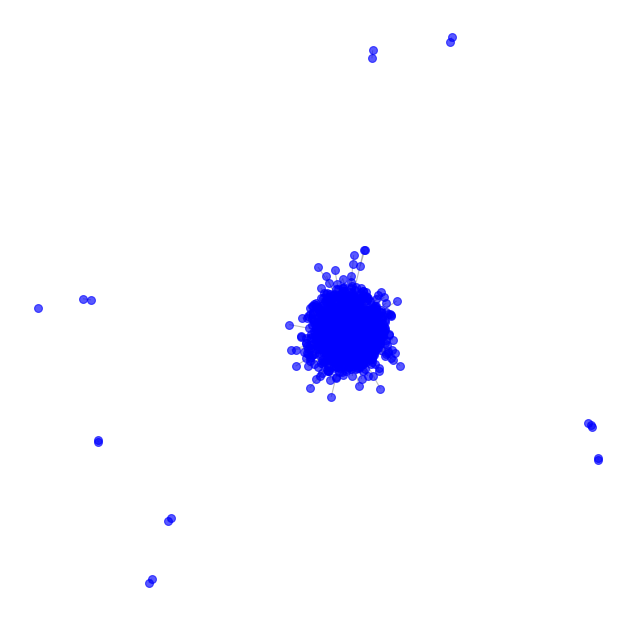

In [24]:
# Make a nice big figure that you can export later for your report: 
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

# generate the positions of the features of the graph using some layout from networkx (https://networkx.github.io/documentation/networkx-1.10/reference/drawing.html)
pos = nx.spring_layout(G)

# remove the unnecessary axes
plt.axis('off')

# draw the nodes - choose nice set of aesthetic properties to make them look fancy
nx.draw_networkx_nodes(G,pos,alpha=0.65,node_size=50,node_color='blue')

# draw the edges - choose nice set of aesthetic properties to make them look fancy
nx.draw_networkx_edges(G,pos,alpha=0.5,edge_color='gray')

# fingers crossed!
plt.show()

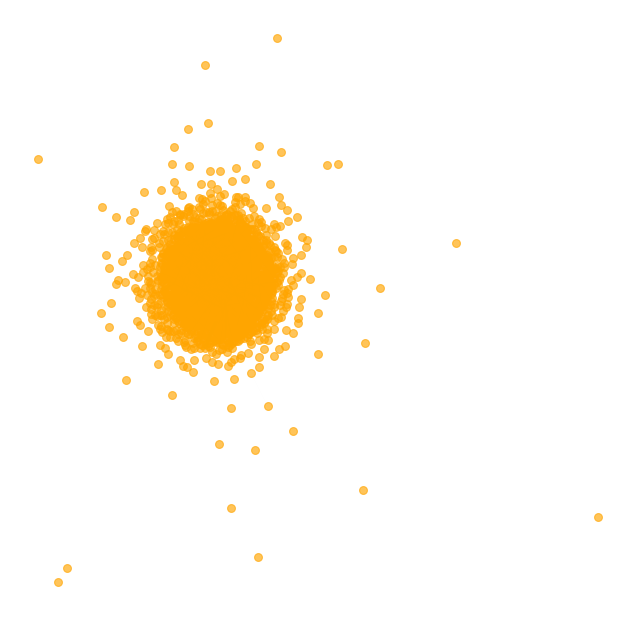

In [25]:
# Make a nice big figure that you can export later for your report: 
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

# generate the positions of the features of the graph using some layout from networkx (https://networkx.github.io/documentation/networkx-1.10/reference/drawing.html)
pos = kamada_kawai_layout_pos

# remove the unnecessary axes
plt.axis('off')

# draw the nodes - choose nice set of aesthetic properties to make them look fancy
nx.draw_networkx_nodes(G,pos,alpha=0.65,node_size=50,node_color='orange')

# draw the edges - choose nice set of aesthetic properties to make them look fancy
nx.draw_networkx_edges(G,pos,alpha=0.01,width=dat['X.times.seen']*3/dat['X.times.seen'].max(),edge_color='gray')

# fingers crossed!
plt.show()

In [26]:
# I was considering weighing edges according to number of times seen but that craps out sigma JS's renderer
dat['X.times.seen'].max()

224

### Output JSON

In [6]:
# We need a table to look up gene IDs and match them to descriptions
lookup_table = ids[['Gene ID','Product Description']]
des = {}
for gene in list(full['source'])+list(full['target']): # for every gene ID in our lookup table
#     print(gene)
    if len(gene) > 0:
        des[gene] = '; '.join(set([ str(lookup_table.loc[lookup_table['Gene ID'] == g,'Product Description'].reset_index(drop=True)[0])
                     for g in gene.replace(';',',').split(',') ]))

In [8]:
# Finally, we want to assign these gene IDs to the clusters reported by Hillier et al.
# We read the data file with the clusters
clu = pd.read_csv('clusters.csv')
clu = dict(zip(clu['GeneID'],clu['Cluster#'])) 
    # make dict from df with gene ID as key and cluster number as value

for gene in lookup_table['Gene ID']: # for every gene ID in our lookup table
    if gene not in clu.keys(): # if no cluster assigned
        clu[gene] = 0 # add to dictionary as coresponding to (fake) cluster zero
        
for gene in list(full['source'])+list(full['target']): # for every gene ID in our lookup table
    if gene not in clu.keys(): # if no cluster assigned
        clu[gene] = 0 # add to dictionary as coresponding to (fake) cluster zero

# We generate a palette of colors corresponding to clusters, using seaborn's default color palette of 10 colors
# We add black as the color of cluster zero
pal = [(0,0,0)] + sns.color_palette(None,max(clu.values())) 

# For truly distinct colors for each cluster, we could've used a cubehelix palette,
# but this was actually hard to discern:
# cubehelix_palette(max(clu.values()), start=2, rot=2, dark=0.1, light=.9, )

In [48]:
def createJSON(dat,suffix):
    # Now we keep only what we'll feed into networkx format
    d = dat["source"] +" "+ dat["target"] + " {'weight':" + dat['X.times.seen'].astype(str) + "}"
    G = nx.parse_edgelist(d) # creates a networkx graph
    pos = nx.kamada_kawai_layout(G)

    # Now we need to construct a json file to be read by sigma.js with all this info
    # adapted from Tim Sainburg's code: https://timsainburg.com/graph-research-notes-wordpress-networkx-sigmajs.html
    # https://github.com/timsainb/graph_research_notes

    nodes = [
        {
            "id": str(i),
            "label": str(i)+': '+des[i],
            "color": "rgba" + str( tuple( (np.array( pal[clu[i]] ) * 255).astype('int') ) + (1,) ) + "",
            "x": int(pos[i][0] * 256),
            "y": int(pos[i][1] * 256),
            "size": 0.01,
            "cluster":clu[i]
        }
        for ni, i in enumerate(G.nodes())
    ]
    links = [
        {
            "id": str(ui),
            "source": u[0],
            "target": u[1]#,
            # Setting alpha to correspond to the number of times seen does not sit well with sigma.js:
            #"color": "rgba(0,0,0," + str(round(item["weight"]/dat['X.times.seen'].max(), 2)) + ")",
        }
        for ui, (u, item) in enumerate(G.edges.items())
    ]

    graph_data = {"nodes": nodes, "edges": links}

    with open('../dat/plasmodium_interactome_'+suffix+'.json', 'w') as f:
        json.dump(graph_data,
                  f, indent=4,)

In [49]:
createJSON(y2h,'y2h')
createJSON(full,'full')
createJSON(hil,'hil')

PF3D7_1321700
455
PF3D7_1339700
0
PF3D7_0809900
416
PF3D7_1322000
249
PF3D7_0624600
62
PF3D7_1235300
0
PF3D7_1248700
504
PF3D7_1302700
0
PF3D7_0722200
470
PF3D7_1023900
92
PF3D7_0404400
0
PF3D7_0418300
0
PF3D7_0629700
448
PF3D7_1325900
0
PF3D7_1361800
354
PF3D7_1323200
325
PF3D7_1329100
95
PF3D7_0724100
0
PF3D7_1469900
0
PF3D7_1332000
0
PF3D7_0216700
0
PF3D7_1335300
0
PF3D7_0903600
393
PF3D7_1337700
0
PF3D7_0316500
0
PF3D7_1303800
329
PF3D7_0707700
0
PF3D7_0904900
0
PF3D7_0922100
381
PF3D7_1338600
0
PF3D7_1319400
466
PF3D7_0705000
0
PF3D7_0710200
0
PF3D7_0826500
151
PF3D7_1027100
0
PF3D7_1133700
0
PF3D7_1448500
0
PF3D7_0310400
411
PF3D7_0416200
0
PF3D7_0604100
0
PF3D7_0616500
0
PF3D7_0933200
266
PF3D7_1223100
133
PF3D7_0802800
291
PF3D7_0204100
0
PF3D7_1252400
0
PF3D7_1340900
582
PF3D7_0725000
0
PF3D7_1014600
570
PF3D7_1335100
0
PF3D7_1406200
273
PF3D7_1471100
0
PF3D7_0205100,PF3D7_0205200
0
PF3D7_1341300
13
PF3D7_1304000
0
PF3D7_0935500
0
PF3D7_1343000
223
PF3D7_1366300
502
PF3D7_1011

PF3D7_0418700
0
PF3D7_0423700
0
PF3D7_1301700
0
PF3D7_0316000
0
PF3D7_1014100
0
PF3D7_0108700
389
PF3D7_1035300
0
PF3D7_1036000
0
PF3D7_1147300
348
PF3D7_1311500
25
PF3D7_1468900
61
PF3D7_0608100
0
PF3D7_0109700
0
PF3D7_0202000
0
PF3D7_1008000
362
PF3D7_0202400
0
PF3D7_1312100
0
PF3D7_0313100
0
PF3D7_0202600
0
PF3D7_1436100
0
PF3D7_0305500
0
PF3D7_0424300
0
PF3D7_0205900
25
PF3D7_0719300
160
PF3D7_0527200
67
PF3D7_1301200
0
PF3D7_0302000
241
PF3D7_0505800
359
PF3D7_0628700
0
PF3D7_0208200
0
PF3D7_1036700
0
PF3D7_0208400
0
PF3D7_0209300
0
PF3D7_1303500
517
PF3D7_0210900
13
PF3D7_0628100
321
PF3D7_0214400
0
PF3D7_0214700
0
PF3D7_0215600
0
PF3D7_0824200
0
PF3D7_1246200
580
PF3D7_1237100
0
PF3D7_0533100
0
PF3D7_1200700
0
PF3D7_0300100
0
PF3D7_1136900
0
PF3D7_0301600
0
PF3D7_0828700
0
PF3D7_1035900
0
PF3D7_1354900
0
PF3D7_1365000
0
PF3D7_0319700
0
PF3D7_0302600
0
PF3D7_0303300
377
PF3D7_0724900
0
PF3D7_1012200
207
PF3D7_0518100
0
PF3D7_0528100
243
PF3D7_1235700
562
PF3D7_0303500
0
PF3D7_140

451
PF3D7_1311300
451
PF3D7_0309500
559
PF3D7_0217300
0
PF3D7_1352500
297
PF3D7_0507500
0
PF3D7_1215900
287
PF3D7_0805700
154
PF3D7_1037100
158
PF3D7_0613900
0
PF3D7_0523100
0
PF3D7_0917900
184
PF3D7_0804900
252
PF3D7_1224000
0
PF3D7_1349200
159
PF3D7_1220300
0
PF3D7_0320800
239
PF3D7_0405900
0
PKNH_0600300;PKNH_1356600
0
PF3D7_1410300
57
PF3D7_1239900
0
PF3D7_1329100
95
PF3D7_0823800
0
PF3D7_0706500
183
PF3D7_0217900
149
PF3D7_1225800
149
PF3D7_1237000
113
PF3D7_1451800
588
PF3D7_0718500
142
PF3D7_1034900
518
PF3D7_0815200
518
PF3D7_1473100
185
PF3D7_0306400
533
PF3D7_0505900
43
PF3D7_1436600
149
PF3D7_1454700
184
PF3D7_1432800
0
PF3D7_0714000
68
PF3D7_0629200
0
PF3D7_0707400
370
PF3D7_1003800
56
PF3D7_1306900
519
PF3D7_1014600
570
PF3D7_1225500
437
PF3D7_0909800
519
PF3D7_0910400
402
PF3D7_1316500
437
PF3D7_1319300
398
PF3D7_1020700
398
PF3D7_0823300
583
PF3D7_1329000
506
PF3D7_0620500
0
PF3D7_1464900
328
PF3D7_0218700
0
PF3D7_0219400
0
PF3D7_1468800
298
PF3D7_1111100
446
PF3D7_05118

PF3D7_0930800
39
PF3D7_0932000
0
PF3D7_1318100
374
PF3D7_1434200
0
PF3D7_0933500
0
PF3D7_1304400
216
PF3D7_1003400
0
PF3D7_1003600
425
PF3D7_1426800
16
PF3D7_1461400
545
PF3D7_1008000
362
PF3D7_1008100
0
PF3D7_1349300
199
PF3D7_1032100
462
PF3D7_1402200
447
PF3D7_1012900
0
PF3D7_1013000
543
PF3D7_1326600
190
PF3D7_1038100
135
PF3D7_1422400
0
PF3D7_1437400
0
PF3D7_1018300
15
PKNH_1148900
0
PF3D7_1020100,PF3D7_1020200
0
PF3D7_1325200
481
PKNH_1032500
0
PKNH_1100900
527
PF3D7_1024800
556
PF3D7_1028400
0
PF3D7_1028500
0
PF3D7_1329400
0
PF3D7_1031200
336
PF3D7_1032900
272
PF3D7_1434500
584
PF3D7_1034700
97
PF3D7_1315700
102
PF3D7_1453900
564
PF3D7_1363200
0
PF3D7_1347400
35
PF3D7_1455800
0
PF3D7_1110100
0
PF3D7_1408900
156
PF3D7_1217400
0
PF3D7_1459800
0
PF3D7_1306500
248
PF3D7_1221900
91
PKNH_1325800
497
PF3D7_1213900
589
PF3D7_1121300
0
PF3D7_1227500
99
PF3D7_1417600
0
PF3D7_1246400
0
PF3D7_1140500
0
PF3D7_1244000
193
PF3D7_1121900
495
PF3D7_1122700
0
PF3D7_1123100
516
PF3D7_1418100
483
P

PF3D7_1214500
0
PF3D7_1031600
0
PF3D7_1465100
0
PF3D7_1337000
0
PF3D7_1219300
0
PF3D7_1220100
0
PF3D7_1221800
0
PF3D7_1222600
0
PF3D7_1225000
0
PF3D7_1227200
0
PF3D7_1227800
0
PF3D7_0830800
0
PF3D7_1228300
0
PF3D7_1241800
0
PF3D7_1233200
0
PF3D7_1353200
0
PF3D7_0926900
0
PF3D7_0704000
0
PF3D7_1431000
0
PF3D7_1205900
0
PF3D7_1238500
0
PF3D7_1318700
0
PF3D7_0809100
0
PF3D7_0617400
0
PF3D7_1245800
0
PF3D7_0726100
0
PF3D7_1357000
0
PF3D7_1233700
0
PF3D7_1250200
0
PF3D7_1250600
0
PF3D7_1352900
0
PF3D7_1252600
0
PF3D7_0102900
151
PKNH_1441400
103
PKNH_1030600
148
PKNH_0600600
208
PF3D7_1138800
0
PF3D7_0826500
151
PF3D7_1209200
101
PF3D7_1107000
11
PF3D7_1124400
0
PF3D7_0822800
24
PF3D7_0807900
207
PF3D7_1117500
0
PF3D7_1136300
309
PF3D7_1336900
0
PF3D7_0627700
309
PF3D7_0813600
124
PF3D7_1243600
48
PF3D7_1126000
516
PF3D7_0308200
44
PF3D7_1129000
0
PF3D7_1125500
0
PF3D7_0717700
309
PF3D7_1355500
0
PF3D7_0503300
555
PF3D7_0923900
3
PF3D7_1002400
548
PF3D7_0904800
175
PF3D7_0826700
2
PF3D7_136

343
PF3D7_0310600
174
PF3D7_1125900
32
PF3D7_0303700
0
PF3D7_0819600
538
PF3D7_0524300
508
PF3D7_1033100
0
PF3D7_1245400
503
PF3D7_1438000
284
PF3D7_0628200
384
PF3D7_1368800
0
PF3D7_1013300
0
PF3D7_1119000
0
PF3D7_1460300
371
PF3D7_1028700
306
PF3D7_0305500
0
PF3D7_1409400
550
PF3D7_1433900
317
PF3D7_0413700
0
PF3D7_0529400
572
PF3D7_1332600
0
PF3D7_1015700
285
PF3D7_1303200
378
PF3D7_1145200
318
PF3D7_0417500
436
PF3D7_1436900
356
PF3D7_1213600
316
PF3D7_1333400
177
PF3D7_0729200
177
PF3D7_0306000
531
PF3D7_1413900
532
PF3D7_1339400
531
PF3D7_0306100
0
PKNH_1472200
390
PF3D7_1313700
225
PF3D7_0512700
0
PF3D7_1244800
0
PF3D7_1328900
0
PF3D7_0808400
463
PF3D7_0520900
120
PF3D7_0317800
578
PF3D7_0925500
0
PF3D7_1006600
500
PF3D7_1231500
0
PF3D7_1125400
382
PF3D7_0515800
278
PF3D7_1437700
533
PF3D7_0530200
297
PF3D7_1420900
303
PF3D7_1214100
297
PF3D7_0918000
522
PF3D7_0406000
0
PF3D7_1132800
452
PF3D7_0306500
520
PF3D7_1346100
520
PF3D7_1430900
447
PF3D7_1108500
0
PF3D7_0722500
0
PF3D7_

PF3D7_1429000
0
PF3D7_1450700
507
PF3D7_1457400
163
PF3D7_1217300
587
PF3D7_1238900
165
PF3D7_1430300
514
PF3D7_1443400
0
PF3D7_1467900
0
PF3D7_1428800
0
PF3D7_1248500
0
PF3D7_1232500
0
PF3D7_1355300
0
PF3D7_1234500
494
PF3D7_1355800
0
PF3D7_1234900
447
PF3D7_1343600
5
PF3D7_1237700
429
PF3D7_1308400
190
PF3D7_1433800
363
PKNH_0516300
0
PF3D7_1415800
0
PF3D7_1443100
0
PF3D7_1325600
527
PF3D7_1465000
515
PF3D7_1328300
371
PKNH_0800800
0
PF3D7_1420300
0
PF3D7_1439600
0
PF3D7_1475500
0
PF3D7_1458700
215
PBANKA_0519200
0
PF3D7_1369400
162
PF3D7_1457000
0
PF3D7_1409200
0
PF3D7_1458900
0
PF3D7_1447600
499
PF3D7_1414100
0
PF3D7_1416100
469
PKNH_1246300
0
PF3D7_1472400
0
PF3D7_1447800
0
PF3D7_1470700
232
PF3D7_1434900
0
PF3D7_1448400
208
